# Synthetic data generation

We try to build a potential data scenario for the application of contextual multi-armed bandit strategies.

The scenario should be characterized by
1. **a context** (i.e. a collection of attributes describing the situation where a specific action is proposed). In this case the context is characterised by a collection of customer features, which could be either continuos, ordinal or categorical.
2. **a series of actions** to propose to the customer (e.g. no offer, mild offer and deep offer) given the context.

The dataset we build should represent a situation where we know in advance which are the actions that have been proposed to each customer and the value of the corresponding rewards. This would allow us to test bench any kind of contextual multi armed bandit solution via the execution of controlled experiments.

The notebook has the following structure

1. [Loading modules](#Loading-modules)
2. [Synthetic data generation](#Synthetic-data-generation)
3. [Input space inspection](#Input-space-inspection)
    * [Continuos features](#Continuos-features)
    * [Ordinal features](#Ordinal-features)
    * [Categorical features](#Categorical-features)
4. [Prediction power vs synthetic noise](#Prediction-power-vs-synthetic-noise)


## Loading modules

In [1]:
import os
import sys
sys.path.append('/Users/fci02/Documents/GitHub/decisioning-analysis/test_and_learn/production_modules/')

from contextual_mab.data_utils.data_generation  import generate_synthetic_data
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from ccp_analysis.ccp_tree_analysis import compute_auc_metrics


## Synthetic data generation

We generate a synthetic dataset with the following shape

1. $3$ available actions
2. $n = 1000$ data points per action played
3. the **global** expected rewards of the actions are $[5\%,3\%,1\%]$
4. The features characterizing the context are
    * 3 continuos, normally distributed with mean vector $[0,10,-3]$ and standard deviations $[1,5.,.5]$
    * 2 ordinal features, with specified frequencies
        \begin{align}
        \text{O_1} &= [1,2,3,4,5,6,7,8,9,10] \quad p = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]\\
        \text{O_2} &= [1,2,3] \quad p = [0.3,0.4,0.3]
        \end{align}
    * 3 categorical features, with specified frequencies
        \begin{align}
        \text{C_1} &= (\text{Yes,No}) \quad p = [0.4,.61]\\
        \text{C_2} &= (\text{Green,Yellow}) \quad p = [0.2,0.8]\\
        \text{C_3} &= (\text{A,B,C}) \quad p = [0.4,0.1,0.5]
        \end{align}
5. For each action $a$, the reward outcome are computed in the following way:
    * a random vector of weights is generated ${\bf w}_{a} \sim \mathcal{N}({\bf 0},{\bf 1})$
    * for a context matrix $X_a$, a probabilities vector is computed via sigmoid function
        \begin{align}
        {\bf z} = {\bf w}^T_a X_a+{\bf \epsilon}\\
        {\bf p} = \frac{1}{1+e^{-{\bf z}}}
        \end{align}
       where $\epsilon$ is a noise term 
       \begin{equation}
       {\bf \epsilon} \sim \mathcal{N}(0, \alpha)
       \end{equation}
       and $\alpha$ is provided by the user. For each row $i$ of $X_a$, a reward value is then assigned using the following criterion
       \begin{align}
       r_i &= 1 \quad \text{if } p_i > (1-\bar{r}_a)\text{-quantile}\\
       r_i &= 0 \quad \text{if } p_i <= (1-\bar{r}_a)\text{-quantile}
       \end{align}
      where $\bar{r}_a$ is provided by the user. In this way we ensure the global expected reward of each action reflects the input value provided by the user.
      For example if $\bar{r}_a=0.1$ then the rule assigns a non zero reward only to those rows whith probabilities belonging to the last decile. 

In [2]:
n = 10000
nc = 3
cw = [.05,.03,.01]

ct_prm = {'X1':{'loc':0.,'scale':1.},
          'X2':{'loc':10.,'scale':5.},
          'X3':{'loc':-.3,'scale':.5}}

ord_prm = {'O1':{'start':1,'stop':11,'weights':[.1]*10},
           'O2':{'start':1,'stop':4,'weights':[.3,.4,.3]}}

catg_prm = {'C1':{'levels':['Yes','No'],'weights':[.4,.6]},
            'C2':{'levels':['Green','Yellow'],'weights':[.2,.8]},
            'C3':{'levels':['A','B','C'],'weights':[.4,.1,.5]}}
seed = 0
noise_scale=5.

In [3]:
synthetic_data = generate_synthetic_data(n,nc,cw,
                       ct_prm,ord_prm,catg_prm,seed,noise_scale,
                       return_inputs=False,output_info=True)

Total number of data: 30000
Actions played: [1, 2, 3]
Global expected rewards per action


,reward
action_code,
1,0.05
2,0.03
3,0.01


In [4]:
synthetic_data.head()

,X1,X2,X3,O1,O2,C1,C2,C3,reward,action_code
0,1.764052,11.856161,-0.838830,8,1,Yes,Green,C,0,1
1,0.400157,11.523919,-0.721146,6,2,No,Green,A,0,1
2,0.978738,12.520623,-0.428904,1,3,Yes,Yellow,C,0,1
3,2.240893,10.676498,0.056038,5,2,Yes,Yellow,C,0,1
4,1.867558,13.268794,-0.027104,7,3,No,Yellow,C,0,1


## Input space inspection

### Continuos features

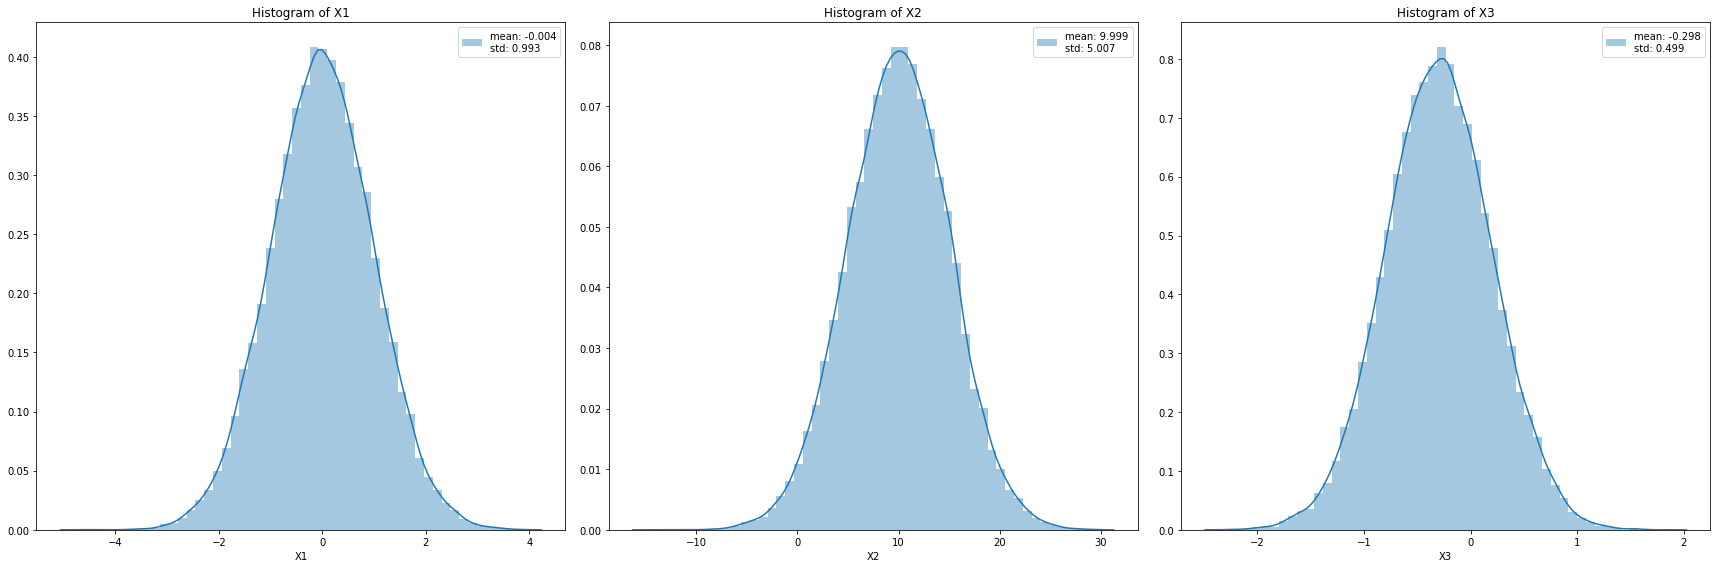

In [5]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))

for feature, ax in zip(['X1','X2','X3'],[ax1,ax2,ax3]):
    sns.distplot(synthetic_data[feature],ax=ax,label='mean: {0:.3f}\nstd: {1:.3f}'.format(synthetic_data[feature].mean(),synthetic_data[feature].std()))
    ax.set_title('Histogram of {}'.format(feature))
    ax.legend()
plt.tight_layout()
plt.show()

### Ordinal features

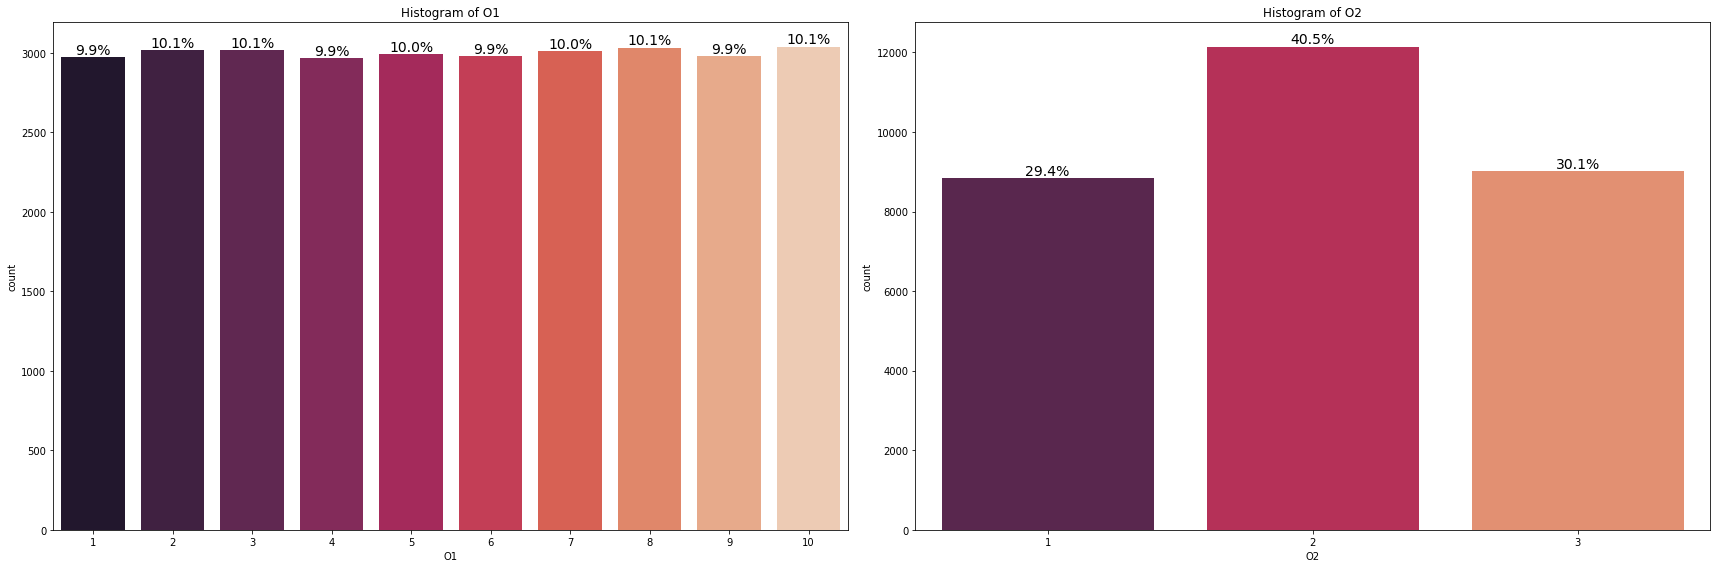

In [6]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

for feature, ax in zip(['O1','O2'],[ax1,ax2]):
    sns.countplot(synthetic_data[feature],palette="rocket",ax=ax,)
    ax.set_title('Histogram of {}'.format(feature))
    ncount = len(synthetic_data[feature])
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom',fontsize=14)
plt.tight_layout()
plt.show()

### Categorical features

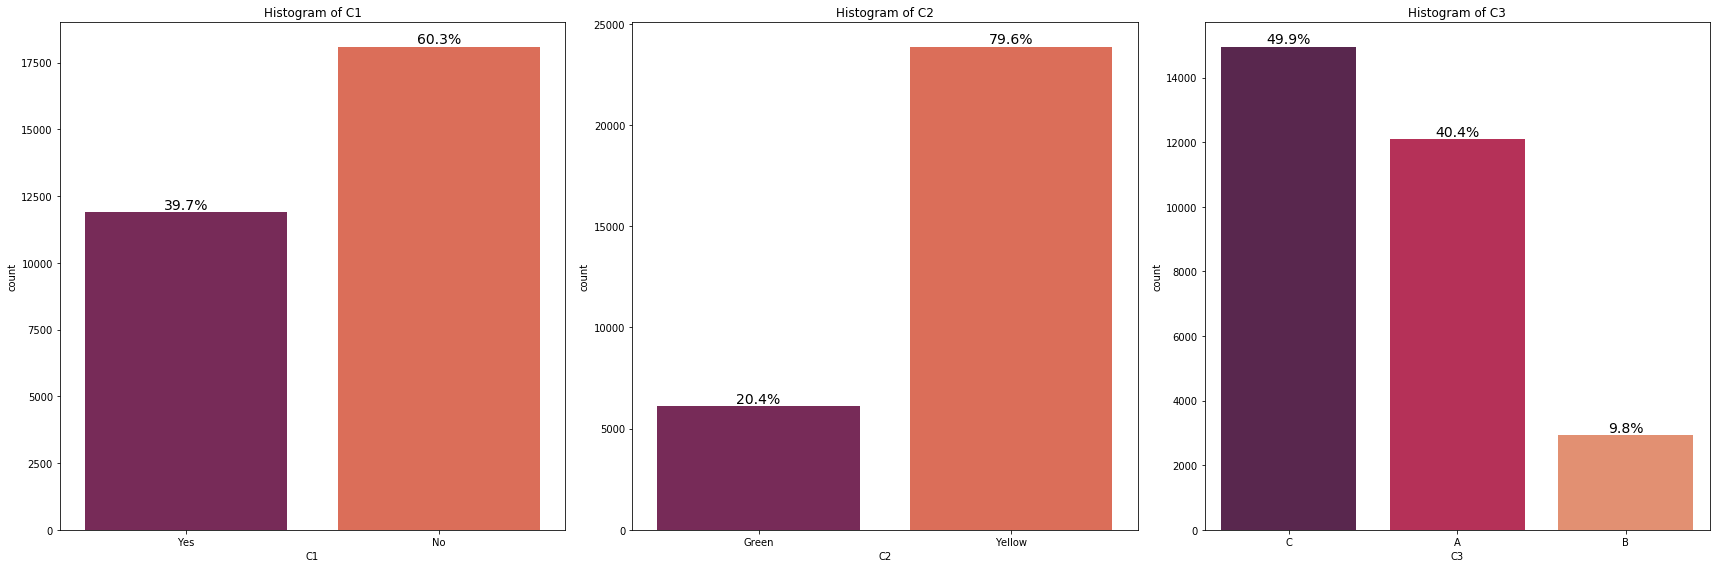

In [7]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))

for feature, ax in zip(['C1','C2','C3'],[ax1,ax2,ax3]):
    sns.countplot(synthetic_data[feature],palette="rocket",ax=ax,)
    ax.set_title('Histogram of {}'.format(feature))
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom',fontsize=14)
plt.tight_layout()
plt.show()

## Prediction power vs synthetic noise

We can define more or less difficult to learn reward distributions by tuning the value of the random noise term $\epsilon$. This would help us in mimicking more realistic scenarios.

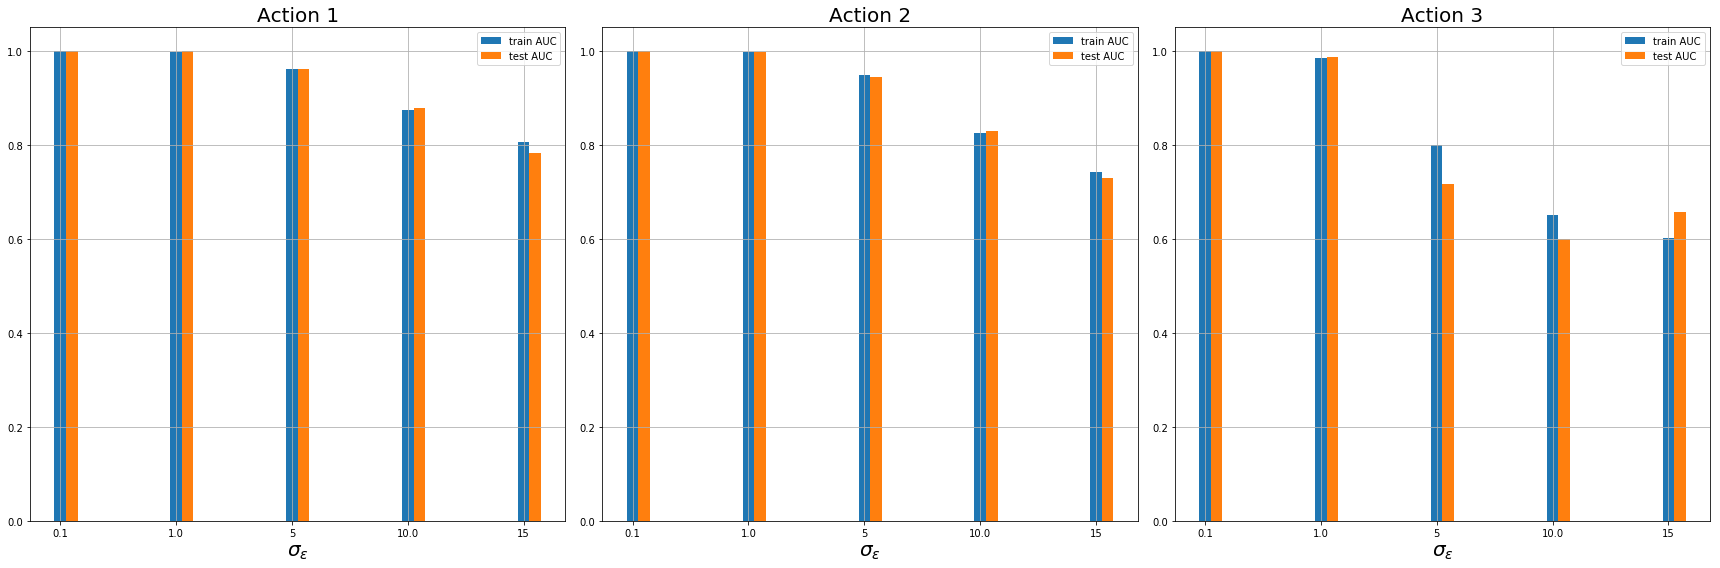

In [11]:
noise_scales = [.1,1.,5,10.,15]
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(24,8))

for action, ax in zip(range(1,4),[ax1, ax2, ax3]):
    noise_perfs = {}
    for noise_scale in noise_scales:
        synthetic_data = generate_synthetic_data(n,nc,cw,
                                                 ct_prm,ord_prm,catg_prm,seed,noise_scale)
        subset = synthetic_data[synthetic_data['action_code']==action]
        X = pd.get_dummies(subset.drop(columns=['reward','action_code']),drop_first=True).values
        y = subset['reward'].values
        X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=.3,stratify=y)
        model = LogisticRegression(solver='lbfgs')
        model.fit(X_train,y_train)
        noise_perfs[str(noise_scale)] = compute_auc_metrics(model,X_train, X_test, y_train, y_test)

    data = pd.DataFrame(noise_perfs)
    w=.1
    ax.bar(np.arange(1,6),data.loc['train',:],width=w,label='train AUC',align='center')
    ax.bar(np.arange(1,6)+w,data.loc['test',:],width=w,label='test AUC',align='center')
    ax.legend()
    ax.set_title('Action {}'.format(action),fontsize=20)
    ax.grid()
    ax.set_xticks(np.arange(1,6))
    ax.set_xticklabels([str(noise_scale) for noise_scale in noise_scales])
    ax.set_xlabel('$\sigma_\epsilon$', fontsize=20)
plt.tight_layout()
plt.show()

It seems we can capture the variability of the reward enough well even for large value of the noise term variance. Larger values have been tried, however in this case it is necessary to use larger sample size per action in order to be able to see non zero outcomes of the reward.